In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




In [38]:
# @title Make a plot of which brain areas are present in each dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [39]:
dat=alldat[11]
wheel=dat['wheel']
wheel= wheel.squeeze()
dt=dat['bin_size']
t_vec=dt*np.arange(wheel.shape[-1])


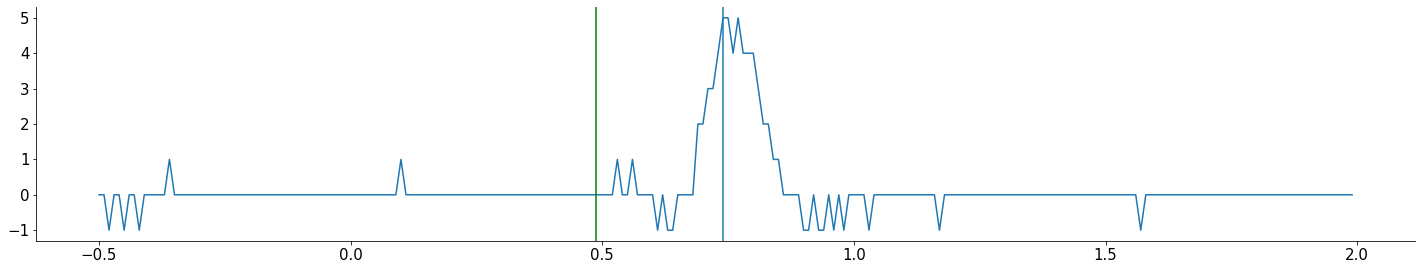

In [36]:
#indices=[i for i in range(0, wheel.shape[-1],50)]
plt.plot(t_vec-0.5,wheel[0,:])
plt.axvline(dat['gocue'][0], color='green')
plt.axvline(dat['reaction_time'][0,0]*1e-3)


In [170]:
def get_valid_trials(dat):
        
        
    reaction_times=np.squeeze(dat['reaction_time'][:,0])  
    
    cue_time=np.squeeze(dat['gocue'][:])
                                            #print("Reaction times:", reaction_times.shape, " :",cue_time.shape)
    ind=(reaction_times[:]-cue_time[:]>0)   # and reaction_times[:]!=np.inf)
                                            #print("Index shape0: ", ind.shape)
    #ind=(reaction_times[ind]<np.inf)       #not sure why this reduce the dimension by 1

    return ind

def get_valid_spks(dat):    
    #print(dat['spks'].shape)
    spks=dat['spks'][:, get_valid_trials(dat)]
    return spks


def weave_brain_grp(alldat, brain_group):
    
    dat_weaved=dict()
    for i,dat in enumerate(alldat):
    
        #print(i, ": ", dat['spks'].shape,"; ",np.sum(dat['brain_area'][:]==brain_group))
        grp_indices=(dat['brain_area'][:]==brain_group)## Take the indices where the data from neurons of the desired group is
        #print(grp_indices)
        valid_trial_indices=get_valid_trials(dat)       ## take the valid trials
        spikes=get_valid_spks(dat)[grp_indices]         
        print(spikes.shape)
        if i==0:
            dat_weaved['spks']=spikes.mean(axis=0)
            dat_weaved['wheel']=np.squeeze(dat['wheel'])[valid_trial_indices]
            dat_weaved['reaction_time']=dat['reaction_time'][valid_trial_indices]
            dat_weaved['contrast_right']=dat['contrast_right']
            dat_weaved['contrast_left']  =dat['contrast_left']
            dat_weaved['gocue'] =dat['gocue'] 
            dat_weaved['response_time']=dat['response_time']  
            dat_weaved['response'] =dat['response']
            dat_weaved['feedback_time']= dat['feedback_time']
            dat_weaved['feedback_type']= dat['feedback_type']
        else:
            dat_weaved['spks']=np.vstack([dat_weaved['spks'],spikes.mean(axis=0)[:][:]])
            dat_weaved['wheel']=np.vstack([dat_weaved['wheel'],np.squeeze(dat['wheel'])[valid_trial_indices]])
            dat_weaved['reaction_time']=np.vstack([dat_weaved['reaction_time'],dat['reaction_time'][valid_trial_indices]])
            dat_weaved['contrast_right']=np.vstack([dat_weaved['contrast_right'],dat['contrast_right']])
            dat_weaved['contrast_left'] =np.vstack([dat_weaved['contrast_left'],dat['contrast_left']])
            dat_weaved['gocue'] =np.vstack([dat_weaved['gocue'],dat['gocue'] ])
            dat_weaved['response_time']=np.vstack([dat_weaved['response_time'],dat['response_time']])  
            dat_weaved['response'] =np.vstack([dat_weaved['response'],dat['response']])
            dat_weaved['feedback_time']= np.vstack([dat_weaved['feedback_time'].dat['feedback_time']])
            dat_weaved['feedback_type']= np.vstack([dat_weaved['feedback_type'],dat['feedback_type']])
        
    return dat_weaved  
        
    
    
    
    

    
def get_brain_grp(alldat, brain_group):
    
        dat_weaved=dict()
    
    
        grp_indices=(dat['brain_area'][:]==brain_group)## Take the indices where the data from neurons of the desired group is
        valid_trial_indices=get_valid_trials(dat)       ## take the valid trials
        spikes=get_valid_spks(dat)[grp_indices]         
        dat_weaved['spks']=spikes.mean(axis=0)
        dat_weaved['wheel']=np.squeeze(dat['wheel'])[valid_trial_indices]
        dat_weaved['reaction_time']=dat['reaction_time'][valid_trial_indices]
        dat_weaved['contrast_right']=dat['contrast_right']
        dat_weaved['contrast_left']  =dat['contrast_left']
        dat_weaved['gocue'] =dat['gocue'] 
        dat_weaved['response_time']=dat['response_time']  
        dat_weaved['response'] =dat['response']
        dat_weaved['feedback_time']= dat['feedback_time']
        dat_weaved['feedback_type']= dat['feedback_type']   
        
        
        return dat_weaved
        

In [172]:
"""
det=weave_brain_grp(alldat, 'VISp')

det['spks'].shape"""

"\ndet=weave_brain_grp(alldat, 'VISp')\n\ndet['spks'].shape"

In [173]:
np.vstack([[[1, 2, 4],[2, 3, 2]], [1, 3, 4]])

array([[1, 2, 4],
       [2, 3, 2],
       [1, 3, 4]])

In [155]:
np.array([[ 3],[ 4]]).shape

(2, 1)